## Esrcizio 07.1
L'esercizio richiede di aggiungere al codice le correzioni di coda a $U$ e $P$. Le correzioni di coda (tail corrections) servono a tenere conto dei contributi al potenziale che vengono trascurati oltre il raggio di cutoff $r_c$. La formula per $P$ è:
$$
P = \rho \cdot \frac{2}{3} \cdot \text{KE} + \frac{p_{\text{tail}} \cdot N + \frac{48}{3} \cdot \text{Viriale}}{V}
$$
con p_{\text{tail} pari a:
$$
p_{\text{tail}} = 32\pi \rho \left( \frac{1}{r_{\text{cut}}^9} - \frac{1}{6\, r_{\text{cut}}^3} \right)
$$
Per $\frac{U}{N}$ invece la formula è:
$$
\frac{U}{N} = U_{\text{tail}} + \frac{4}{N} \sum_{i<j} \left( \frac{1}{r_{ij}^{12}} - \frac{1}{r_{ij}^{6}} \right)
$$
con $U_{\text{tail}}$ pari a:
$$
U_{\text{tail}} = \frac{8 \pi \rho}{9} \left( \frac{1}{r_{\text{cut}}^9} - 3 \cdot \frac{1}{r_{\text{cut}}^3} \right)
$$

## Esercizio 07.2
L'esercizio richiede di eseguire una simulazione Monte-Carlo($N,V,T$) e di dinamica molecolare ($N,V,E$) di un gas con potenziale di Lennard-Jones. L'obbiettivo è calcolare la funzione di autocorrelazione di $\frac{U}{N}$ e stimare l'incertezza statistica calcolata col data-blocking su $\frac{U}{N}$, in funzione della lunghezza $L$ dei blocchi. Le condizioni iniziali per le simulazioni sono: $\rho^\star = 0.8$, $T^\star = 1.1$, $r^\star_c = 2.5$, per MD $dt^\star=0.001$. Il totale di dati presi per le due simulazioni è $500000$.

# Autocorrelazione con fft

**Simulazione MD**

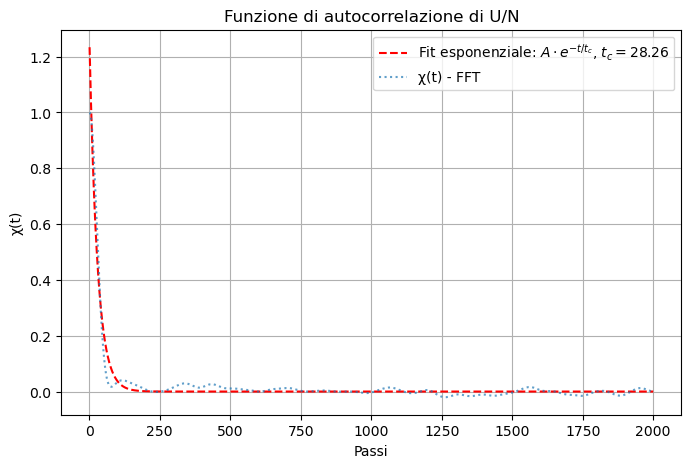

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#carico i dati
data =np.loadtxt("MD/potential_energy.dat", comments="#")
un_istantaneo = data[:, 1]
time = data[:, 0].astype(int)

#funzione di autocorrelazione fft
def autocorrelation_fft(x, max_lag=None):
    x = x - np.mean(x)  # centro la serie
    n = len(x)
    if max_lag is None or max_lag > n:
        max_lag = n

    f = np.fft.fft(x, n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real
    acf /= acf[0]  # normalizzazione
    return acf[:max_lag]

fft_t = autocorrelation_fft(un_istantaneo, max_lag=len(time))

#definizione della funzione da fittare con l'autocorrelazione
def exp_fit(t, A, t_c):
    return A * np.exp(-t / t_c)

params,_ = curve_fit(exp_fit, time, fft_t, p0=[fft_t[0], 1.0])
A_fit, t_c_fit = params

#creo grafico
plt.figure(figsize=(8, 5))
#plotto l'autocorrelazione e la funzione fittata per i primi 2000 steps
plt.plot(time[:2000],exp_fit(time[:2000], *params),label=fr"Fit esponenziale: $A \cdot e^{{-t/t_c}}$, $t_c = {t_c_fit:.2f}$",color="red",linestyle="--") #* davanti a params estrae separatamente i valori nell'array params
plt.plot(time[:2000], fft_t[:2000], label="χ(t) - FFT", linestyle=":", alpha=0.7)

plt.xlabel("Passi")
plt.ylabel("χ(t)") 
plt.title("Funzione di autocorrelazione di U/N") 
plt.grid(True)
plt.legend()
plt.show()

**Simulazione MC**

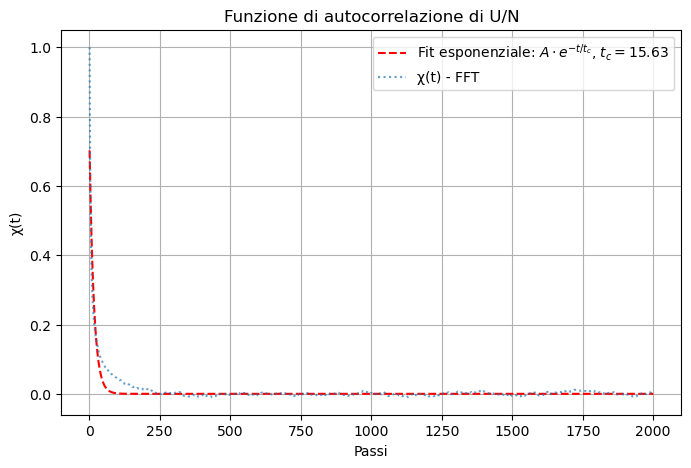

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#carico i dati
data =np.loadtxt("MC/potential_energy.dat", comments="#")
un_istantaneo = data[:, 1]
time = data[:, 0].astype(int)

#funzione di autocorrelazione fft
def autocorrelation_fft(x, max_lag=None):
    x = x - np.mean(x)  # centro la serie
    n = len(x)
    if max_lag is None or max_lag > n:
        max_lag = n

    f = np.fft.fft(x, n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real
    acf /= acf[0]  # normalizzazione
    return acf[:max_lag]

fft_t = autocorrelation_fft(un_istantaneo, max_lag=len(time))

#definizione della funzione da fittare con l'autocorrelazione
def exp_fit(t, A, t_c):
    return A * np.exp(-t / t_c)

params,_ = curve_fit(exp_fit, time, fft_t, p0=[fft_t[0], 1.0])
A_fit, t_c_fit = params

#creo grafico
plt.figure(figsize=(8, 5))
#plotto l'autocorrelazione e la funzione fittata per i primi 2000 steps
plt.plot(time[:2000],exp_fit(time[:2000], *params),label=fr"Fit esponenziale: $A \cdot e^{{-t/t_c}}$, $t_c = {t_c_fit:.2f}$",color="red",linestyle="--") #* davanti a params estrae separatamente i valori nell'array params
plt.plot(time[:2000], fft_t[:2000], label="χ(t) - FFT", linestyle=":", alpha=0.7)

plt.xlabel("Passi")
plt.ylabel("χ(t)") 
plt.title("Funzione di autocorrelazione di U/N") 
plt.grid(True)
plt.legend()
plt.show()

## Analisi e confronto
L’autocorrelazione di una serie temporale (o di dati sequenziali) misura quanto i valori della serie siano correlati con i valori a un certo lag (ritardo) rispetto a se stessi. E' stata calcolata in due modi: fft e attraverso il calcolo di 
$$
\chi(t) = \frac{
\frac{1}{t_{\max} - t} \sum_{t'=0}^{t_{\max} - t} m(t') m(t' + t) \;-\; \left( \frac{1}{t_{\max} - t} \sum_{t'=0}^{t_{\max} - t} m(t') \right) \left( \frac{1}{t_{\max} - t} \sum_{t'=0}^{t_{\max} - t} m(t' + t) \right)
}{
\frac{1}{t_{\max}} \sum_{t'=0}^{t_{\max}} m^2(t') \;-\; \left( \frac{1}{t_{\max}} \sum_{t'=0}^{t_{\max}} m(t') \right)^2
}
$$
E' mostrato solo lo script python con fft perchè computazionalmente più efficiente. I dati sono stati fittati con un esponenziale decrescente. Si noti in ogni caso che la stima su $t_c$ corrisponde per entrambi i metodi. 

La funzione di autocorrelazione $\chi(t)$ di molti processi stocastici con memoria finita ha tipicamente la forma di un esponenziale decrescente:

$$
\chi(t) \approx e^{-t / t_c}
$$

dove $t_c$ è il tempo di correlazione del processo, rappresenta la scala temporale su cui la funzione di autocorrelazione decade significativamente. Dal confronto tra i due grafici è evidente una maggiore correlazione tra i dati della simulazione MD rispetto alla simulazione MC. Per MC infatti $\chi(t)$ va a zero per $t \approx 250$ mentre per MD ci sono ancora fluttuazioni per $t \approx 500$.

Il tempo di correlazione $t_c$ nella simulazione Monte Carlo (MC) è generalmente minore rispetto a quello nella simulazione Molecular Dynamics (MD) perché in MC ogni nuova configurazione viene generata tramite una mossa casuale che viene accettata o rifiutata secondo il criterio di Metropolis.  
Di conseguenza:
- Non esiste un’evoluzione temporale continua e deterministica, come invece avviene in MD.
- Le configurazioni possono cambiare in modo brusco da un passo all’altro, senza seguire una traiettoria temporale fluida.
- Questo favorisce una decorrelazione più rapida tra configurazioni successive, con un tempo di correlazione $t_c$ generalmente più breve.
In MD, invece, la dinamica segue le leggi di moto classiche, quindi i cambiamenti sono continui e correlati nel tempo, portando a tempi di correlazione più lunghi.

## Incertezza in funzione di $L$

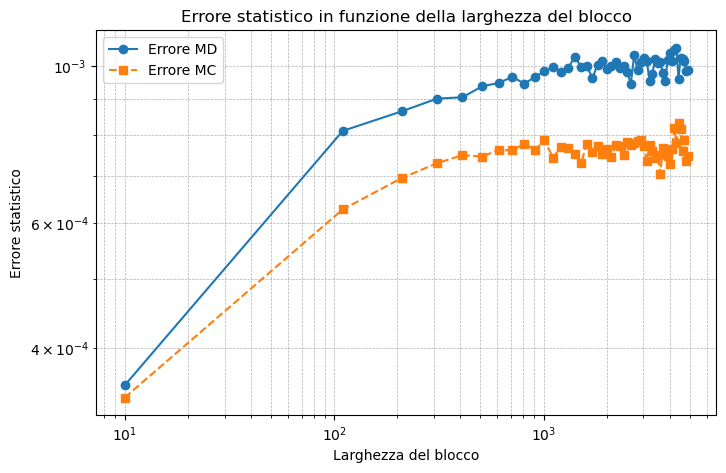

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# carico i dati
data_MD = np.loadtxt("MD/potential_energy.dat", comments="#")
data_MC = np.loadtxt("MC/potential_energy.dat", comments="#")

# salvo solo i dati della seconda colonna (indice 1)
un_istantaneo_MD = data_MD[:, 1]
un_istantaneo_MC = data_MC[:, 1]

# numero totale degli step
M_MD = len(un_istantaneo_MD)
M_MC = len(un_istantaneo_MC)

#array per errore e range blocchi (stesso range per entrambi)
range_blk = np.arange(10, 5001, 100)

error_MD = []
error_MC = []

for L in range_blk:
    # numero di blocchi
    N_MD = M_MD // L
    N_MC = M_MC // L
    
    # medie di blocco per MD
    mean_MD = [np.mean(un_istantaneo_MD[L*i:L*(i+1)]) for i in range(N_MD)]#calcolo le medie di blocco
    mean_MD = np.array(mean_MD)#calcolo la media cumulativa finale sui N blocchi
    err_MD = np.sqrt((np.mean(mean_MD**2) - np.mean(mean_MD)**2) / N_MD)#calcolo dell'errore con data blocking sulla media cumulativa del blocco a lunghezza L
    error_MD.append(err_MD)#salvo l'errore su un array
    
    # medie di blocco per MC
    mean_MC = [np.mean(un_istantaneo_MC[L*i:L*(i+1)]) for i in range(N_MC)]
    mean_MC = np.array(mean_MC)
    err_MC = np.sqrt((np.mean(mean_MC**2) - np.mean(mean_MC)**2) / N_MC)
    error_MC.append(err_MC)

error_MD = np.array(error_MD)
error_MC = np.array(error_MC)

# creo il grafico
plt.figure(figsize=(8, 5))
#plotto i due errori in funzione di L
plt.plot(range_blk, error_MD, marker='o', linestyle='-', label="Errore MD")
plt.plot(range_blk, error_MC, marker='s', linestyle='--', label="Errore MC")
#assi in scala logaritmica
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Larghezza del blocco")
plt.ylabel("Errore statistico")
plt.title("Errore statistico in funzione della larghezza del blocco")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.show()

## Analisi e confronto
All'inizio, con valori piccoli di $L$, l'errore è sottostimato perché il numero di blocchi $N = M/L$ è molto grande.  
Questo comporta due effetti principali:
- I blocchi sono troppo corti per rompere efficacemente le correlazioni temporali tra i dati, quindi le medie di blocco non sono indipendenti.
- La sottostima dell'errore deriva quindi sia dall'eccessivo numero di blocchi sia dalla persistenza di correlazioni residue all’interno dei blocchi.
Man mano che $L$ aumenta, l'errore stimato si stabilizza attorno a un certo valore, anche se si osservano delle oscillazioni. Queste oscillazioni sono fluttuazioni normali dovute alla natura casuale dei valori di $U/N$.

Se si continua ad aumentare $L$ fino a valori comparabili con $M$, il numero di blocchi $N$ diventa molto piccolo.  
In questa situazione:
- Le fluttuazioni dell'errore stimato diventano più marcate e "violente".
- L'errore risulta sovrastimato perché si basa su poche medie di blocco molto variabili.
- L'incertezza sull'errore stesso cresce in modo significativo, rendendo la stima meno affidabile.
- Tuttavia in questa situazione non si osserva tale fenomeno perchè $M=500000$ e $L_{\max} = 5000$.

Si osserva anche che entrambi i tipi di simulazione giungono a una sorta di plateau. In conclusione la scelta ottimale della lunghezza di blocco deve tenere conto di questi due fattori.

Si osserva che l'errore MC risulta minore dell'errore MD, tale differenza è dovuta alla maggiore correlazione dei dati nei blocchi di MD. L'incertezza sulla media è pari a
$$
\sigma_{\bar{X}} = \frac{\sigma}{\sqrt{M}}
$$
con $M$ numero di dati indipendenti; ora, in base alla simulazione il numero effettivo di dati indipendneti è
$$
M_{\text{eff}} \approx \frac{M}{2t_c}
$$
di conseguenza l'errore stimato risulta maggiore in una simulazione MD.

# Esercizio 07.3
L'esercizio richiede di aggiungere al codice il calcolo della distribuzione radiale $g(r)$. Questa funzione esprime quanto è probabile trovare una particella a distanza $r$ da un’altra, rispetto a un sistema ideale (gas perfetto) in cui le particelle sono distribuite casualmente.

$$
g(r) = \frac{\text{densità locale a distanza } r}{\text{densità media del sistema}}
$$

- Se $ g(r) = 1 $: le particelle sono distribuite come in un gas ideale.
- Se $ g(r) > 1 $: è più probabile trovare una particella a distanza $ r $ , maggiore correlazione.
- Se $ g(r) < 1 $: è meno probabile, minore correlazione.
- Se $ g(r) = 0 $: la distanza $ r $ è vietata.

La formula per il calcolo di $g(r)$ è:
$$
g(r) = \frac{1}{\rho N \, \Delta V(r)} \sum_{\substack{i,j=1 \\ i \neq j}}^{N} \delta\left( \left| \vec{r} \right| - \left| \vec{r}_i - \vec{r}_j \right| \right)
\quad \text{con} \quad
r \in [r, r+dr], \quad \theta \in [0, \pi], \quad \phi \in [0, 2\pi]
$$
con $\Delta V$ pari al volume del guscio sferico tra r e dr:
$$
\Delta V(r) = \frac{4}{3} \pi \left( (r + dr)^3 - r^3 \right)
$$

In pratica, durante la simulazione, si riempie un istogramma incrementando di $2$ il conteggio del bin corrispondente alla distanza $ r $ ogni volta che si trovano due particelle a una distanza compresa tra $ r $ e $ r + dr $.  
Successivamente, l’istogramma è normalizzato dividendo per la quantità $ \rho N \, \Delta V(r) $.

# Esercizio 07.4
L'esercizio richiede di effettuare una simulazione **MC NVT** e una simulazione **MD NVE** in un potenziale di Lennard-Jones dell'argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ ($r_c = 2.5$).

Le grandezze da misurare sono la pressione $P$, la distribuzione radiale $g(r)$ e l'energia potenziale per particella $U/N$. Il sistema è stato simulato per $20$ blocchi da $2000$ passi ciascuno valutando l'incertezza con il metodo di data-blocking.

**Energia potenziale per particella**

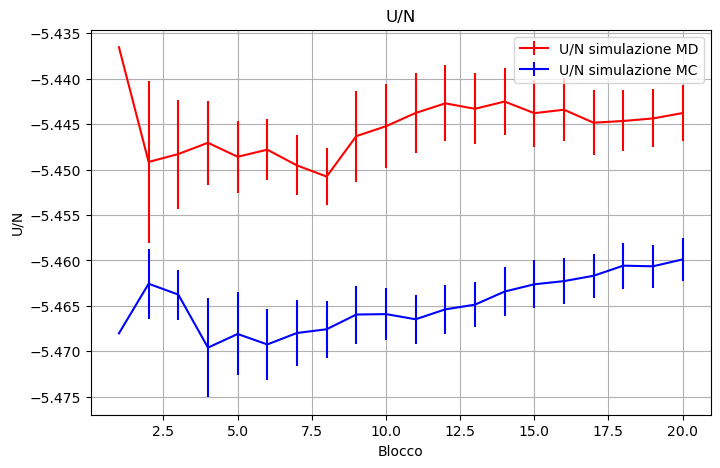

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati
data_MD =np.loadtxt("es7.4/MD/potential_energy.dat", comments="#")
data_MC =np.loadtxt("es7.4/MC/potential_energy.dat", comments="#")

block = data_MD[:,0] #uguali per entrambe le simulazioni
U_MD = data_MD[:,2]
error_MD = data_MD[:,3]
U_MC = data_MC[:,2]
error_MC = data_MC[:,3]
#creo il grafico
plt.figure(figsize=(8, 5))
#plotto i dati con gli errori
plt.errorbar(block, U_MD, yerr=error_MD, color = "red", label="U/N simulazione MD")
plt.errorbar(block, U_MC, yerr=error_MC, color = "blue", label="U/N simulazione MC")

plt.xlabel("Blocco")
plt.ylabel("U/N")
plt.title("U/N")
plt.grid(True)
plt.legend()
plt.show()


**Pressione**

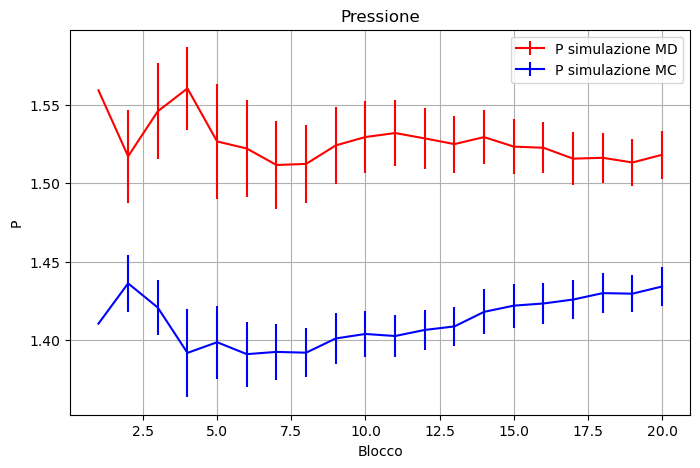

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati
data_MD =np.loadtxt("es7.4/MD/pressure.dat", comments="#")
data_MC =np.loadtxt("es7.4/MC/pressure.dat", comments="#")

block = data_MD[:,0] #uguali per entrambe le simulazioni
P_MD = data_MD[:,2]
error_MD = data_MD[:,3]
P_MC = data_MC[:,2]
error_MC = data_MC[:,3]
#creo il grafico
plt.figure(figsize=(8, 5))
#plotto i dati con gli errori
plt.errorbar(block, P_MD, yerr=error_MD, color = "red", label="P simulazione MD")
plt.errorbar(block, P_MC, yerr=error_MC, color = "blue", label="P simulazione MC")

plt.xlabel("Blocco")
plt.ylabel("P")
plt.title("Pressione")
plt.grid(True)
plt.legend()
plt.show()


**Distribuzione radiale**

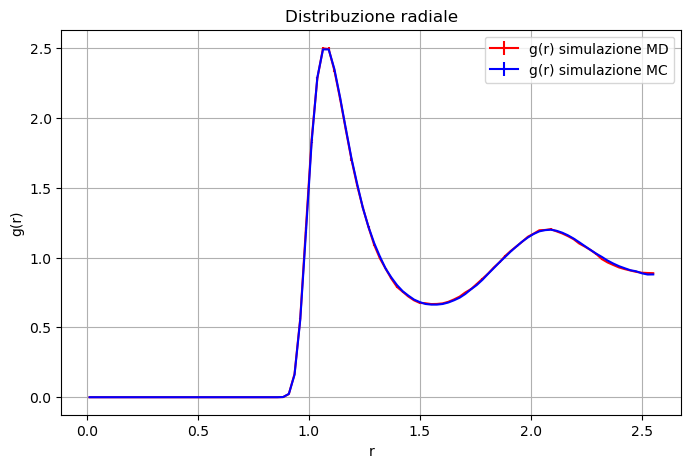

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati dell'ultimo blocco delle simulazioni
data_MD =np.loadtxt("es7.4/MD/gofr_block_20.dat", comments="#")
data_MC =np.loadtxt("es7.4/MC/gofr_block_20.dat", comments="#")

r = data_MD[:,0] #uguali per entrambe le simulazioni
g_MD = data_MD[:,2]
error_MD = data_MD[:,3]
g_MC = data_MC[:,2]
error_MC = data_MC[:,3]
#creo il grafico
plt.figure(figsize=(8, 5))
#plotto i dati con gli errori
plt.errorbar(r, g_MD, yerr=error_MD, color = "red", label="g(r) simulazione MD")
plt.errorbar(r, g_MC, yerr=error_MC, color = "blue", label="g(r) simulazione MC")

plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Distribuzione radiale")
plt.grid(True)
plt.legend()
plt.show()

## Analisi e confronto
Dai grafici emerge che i valori di pressione e energia interna per particella differiscono nelle due simulazioni, seppur di poco. La distribuzione radiale invece combacia perfettamente. Evidentemente $P$ e $U/N$ sono più sensibili al metodo di campionamento e la discrepanza è attribuibile al diverso modo in cui i due metodi esplorano lo spazio delle configurazioni e alle fluttuazioni statistiche.

Nel grafico della distribuzione radiale si osserva un massimo assoluto per $r \approx \sigma 1.2$ che indica la distanza più probabile di interazione tra le particelle, cioè il raggio di “primo vicino”; un secondo massimo si ha per $r \approx 2.1$ e indica la presenza di un ordinamento a corto raggio più ampio. Questo significa che, oltre ai primi vicini immediati (primo picco), le particelle tendono a disporsi anche in “gusci” successivi intorno a una particella centrale, creando una struttura organizzata fino a una certa distanza. Per distanze grandi, cioè per $ r \to \infty ,  g(r) \to 1 $, come previsto in un liquido omogeneo e isotropo, dove le particelle sono distribuite uniformemente senza correlazioni a lungo raggio. Fino a $r \approx 0.8$ $g(r) = 0$, cioè in questa regione le posizioni sono proibite a causa della forte repulsione tra particelle nel liquido.

## Conclusioni
Il confronto tra le simulazioni Monte Carlo (ensemble NVT) e Dinamica Molecolare (ensemble NVE) consente di valutare l’accordo tra metodi con dinamiche differenti, ma che campionano lo stesso sistema fisico. Nonostante lievi differenze nelle proprietà termodinamiche come pressione ed energia potenziale per particella, la perfetta sovrapposizione della funzione di distribuzione radiale conferma che entrambi i metodi riescono a descrivere correttamente la struttura microscopica del liquido. Le differenze residue sono imputabili alle diverse modalità di esplorazione dello spazio delle configurazioni.